In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
import numpy as np

from acoustics.plot import plot

## Rigid Backed Porous Absorber

These are the generic absorbers commonly shown in DYI build vidoes and posts. They are also offered for sale by various companies, e.g. https://www.musiccityacoustics.com/.

* https://github.com/ChrisWhealy/porous_absorber/blob/master/src/calc_engine/perforated_panel.rs#L122
* links to excell Porous Absorber Calculator V1.60 Office 365
* https://gearspace.com/board/studio-building-acoustics/625978-common-gas-flow-resistivity-numbers.html
* https://docs.google.com/spreadsheets/d/19q-20qTpKV5g12PiSc1gNrJlG8DYrtqaFeFoYUCxC68/edit#gid=861262967

Code is in shared.py, so that it can be used across notebooks in this directory.

In [4]:
from shared import materials, porous_absorber

In [5]:
# the frequencies over which to run the calculations
f = np.arange(15, 20000, 1)

## Flow Resisitivity (sigma)

Different theoretical porous absorbent materials

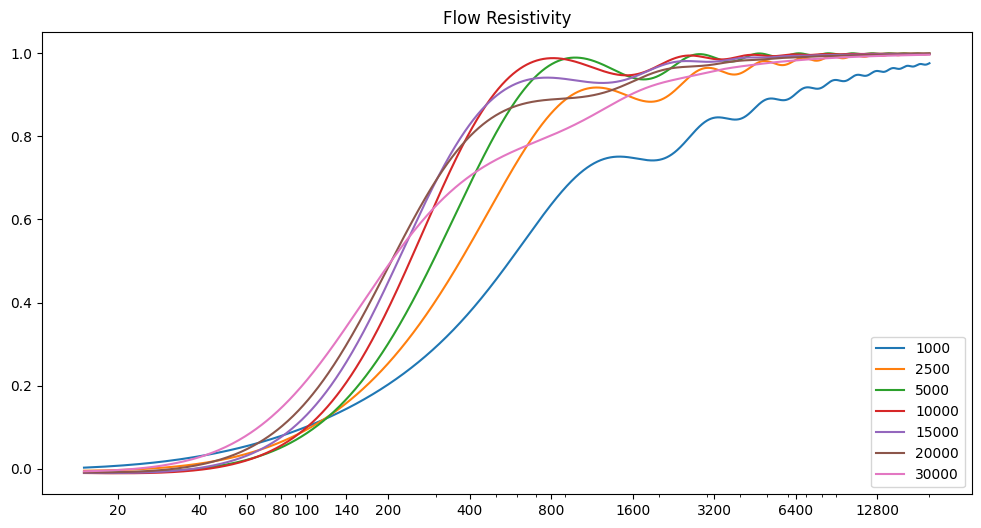

In [6]:
ax = plot(
    f,
    {
        f"{s}": porous_absorber(f, sigma=s, thickness=0.0254 * 3.5, air_gap=0, angle=0)
        for s in (1000, 2500, 5000, 10000, 15000, 20000, 30000)
    },
    title="Flow Resistivity",
    loc="lower right",
)

## Angle of Incidence

The angle at which sound arrives impacts the effectiveness of the absorber. 

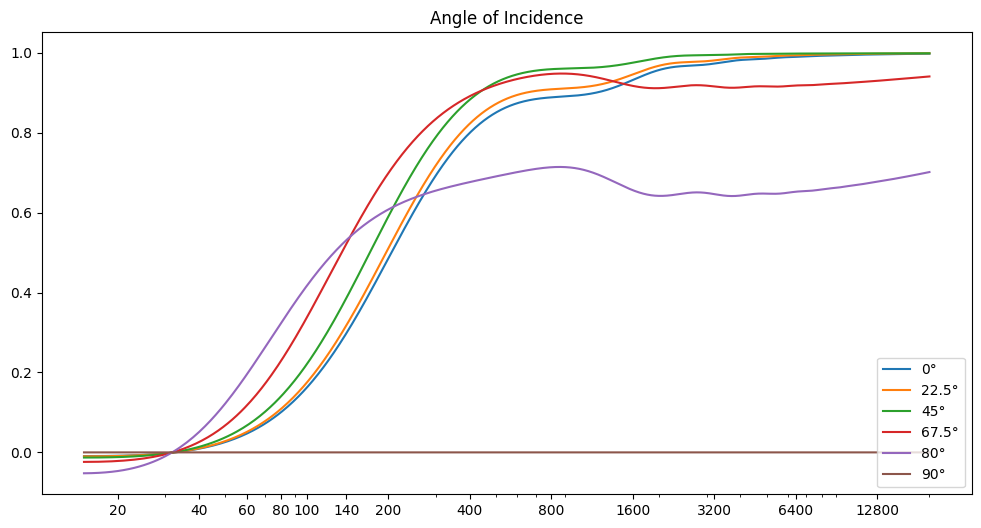

In [7]:
ax = plot(
    f,
    {
        f"{a}°": porous_absorber(
            f, sigma=20000, thickness=0.0254 * 3.5, air_gap=0, angle=a
        )
        for a in (0, 22.5, 45, 67.5, 80, 90)
    },
    title="Angle of Incidence",
    loc="lower right",
)

## Thickness

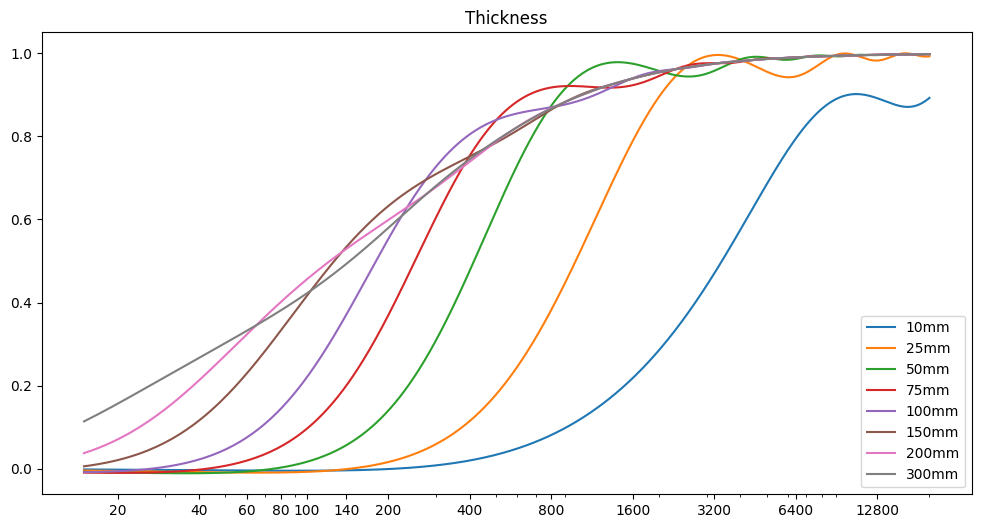

In [8]:
ax = plot(
    f,
    {
        f"{t*1000:.0f}mm": porous_absorber(
            f, sigma=20000, thickness=t, air_gap=0, angle=0
        )
        for t in (0.01, 0.0254, 0.050, 0.075, 0.1, 0.15, 0.2, 0.3)
    },
    title="Thickness",
    loc="lower right",
)

## Air Gap

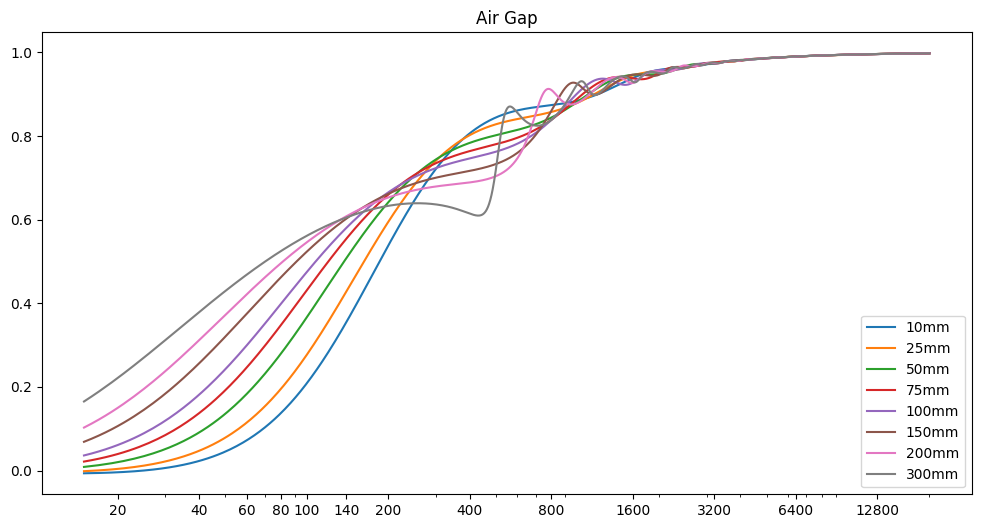

In [9]:
ax = plot(
    f,
    {
        f"{g*1000:.0f}mm": porous_absorber(
            f, sigma=20000, thickness=0.0254 * 3.5, air_gap=g, angle=0
        )
        for g in (0.01, 0.0254, 0.050, 0.075, 0.1, 0.15, 0.2, 0.3)
    },
    title="Air Gap",
    loc="lower right",
)

# Real World Materials

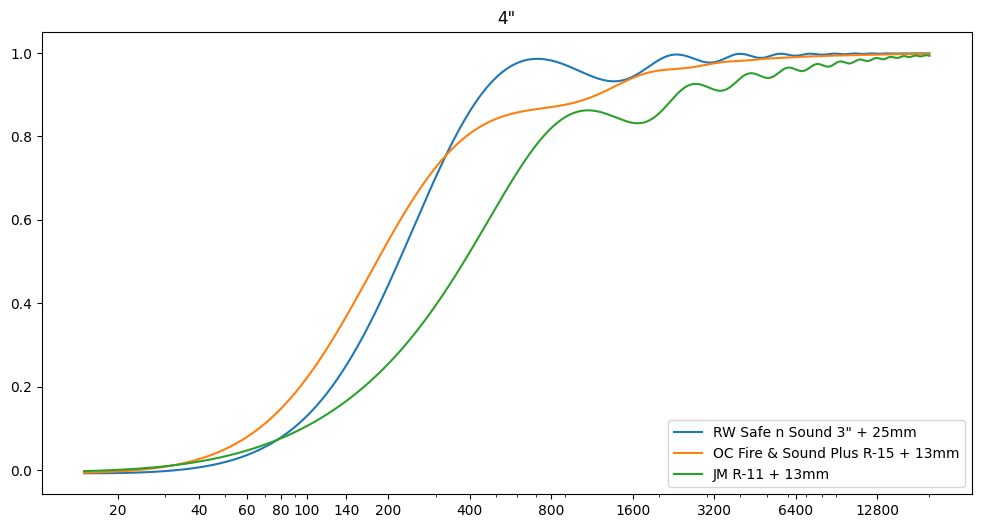

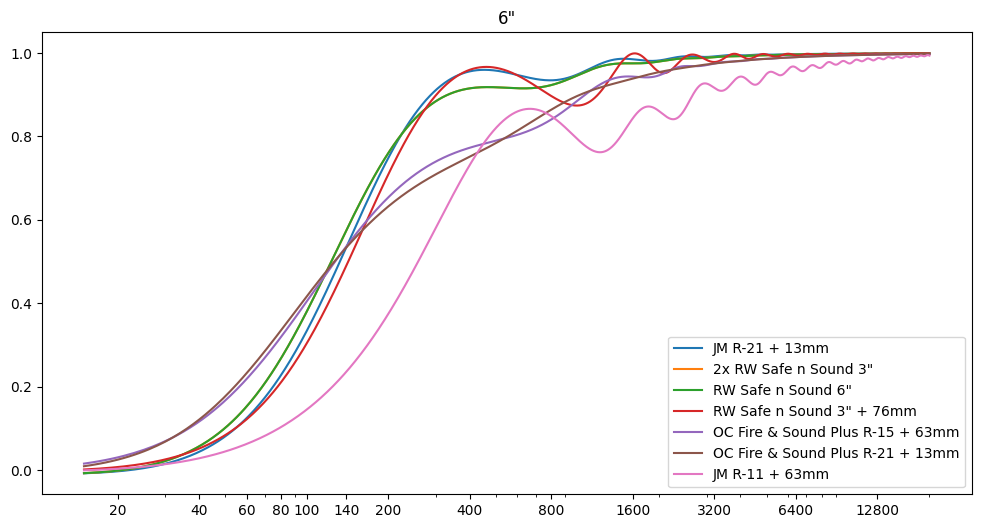

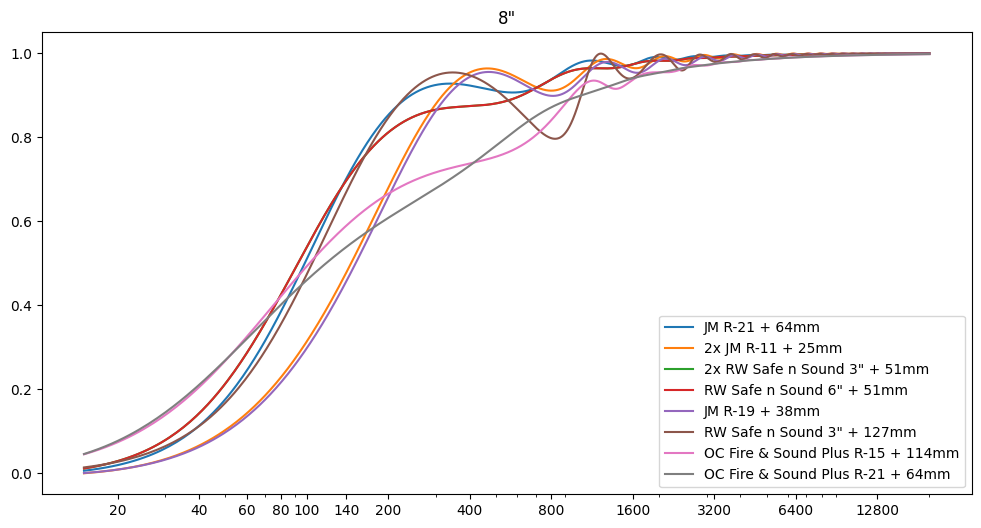

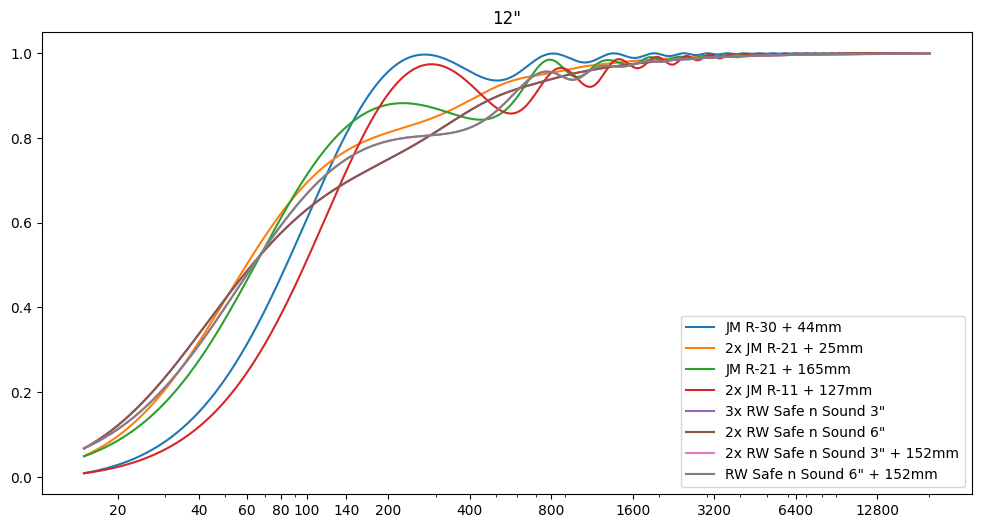

In [10]:
for depth in (4, 6, 8, 12):
    depth *= 0.0254
    configs = []
    for name, info in materials.items():
        thickness = info["thickness"]
        i = 1
        while thickness <= depth:
            air_gap = depth - thickness
            a = porous_absorber(
                f, sigma=info["sigma"], thickness=thickness, air_gap=air_gap
            )
            if i == 1:
                label = name
            else:
                label = f"{i}x {name}"
            if air_gap > 0:
                label = f"{label} + {air_gap*1000:.0f}mm"
            configs.append((label, a, thickness / depth))
            thickness += thickness
            i += 1

    # TODO: sort these by some sort of performance score rather than just how much they fill the space
    configs.sort(key=lambda d: d[2], reverse=True)
    configs.sort(key=lambda d: sum(d[1]), reverse=True)
    configs = {c[0]: c[1] for c in configs[:8]}

    plot(f, configs, title=f'{depth / 0.0254:.0f}"', loc="lower right")

# Model vs Manufacturer Numbers

Interestingly the manufacturer's spec sheet numbers for absorption coefficents are pretty divergent from the model's results. It has been suggested this is due to edge effects in the measurement process that aren't included in the model. It's also not clear that one manufacturer's numbers are comparable to anothers. It will be interesting to see how well reality agrees with the model and/or specs in the actual room.

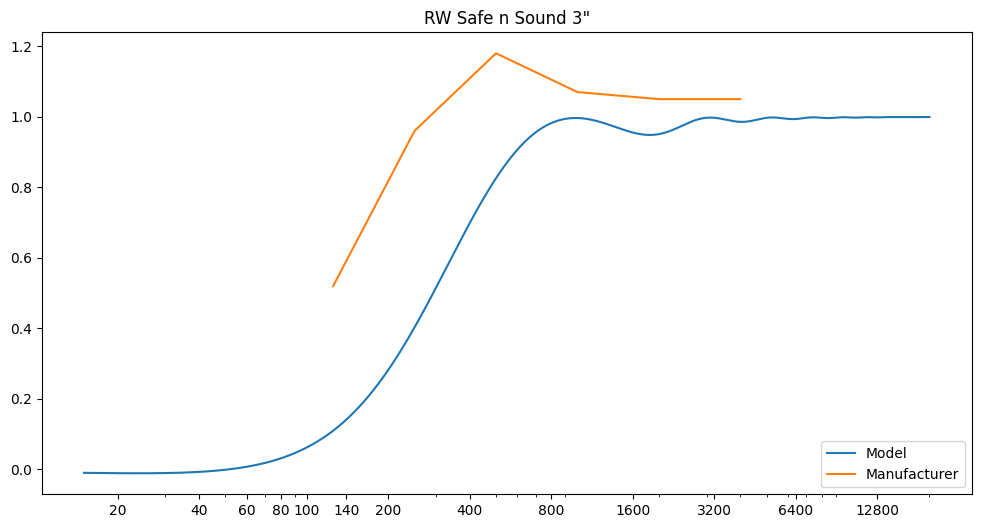

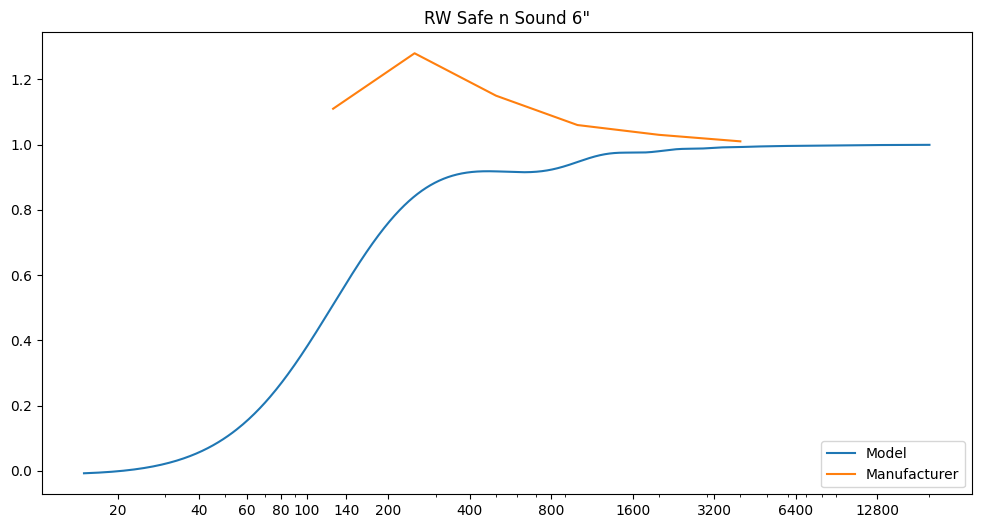

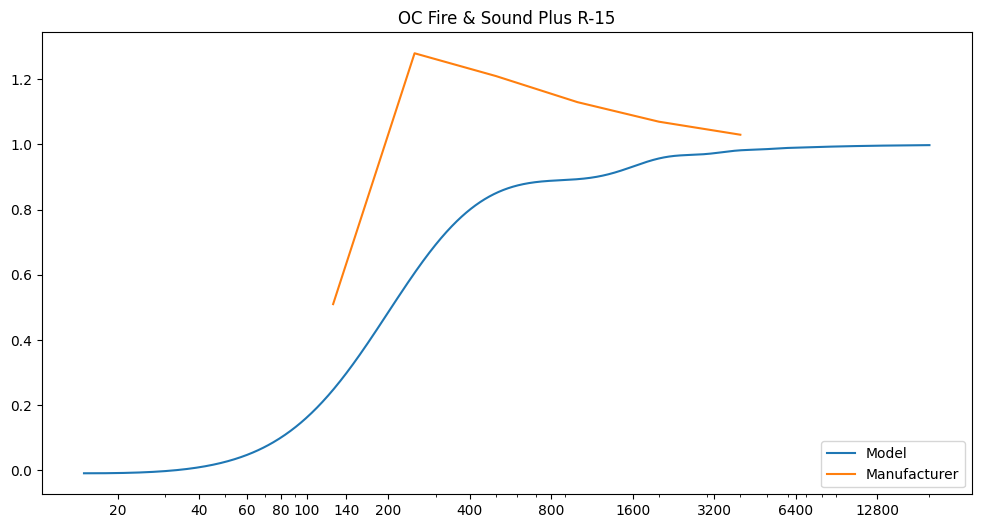

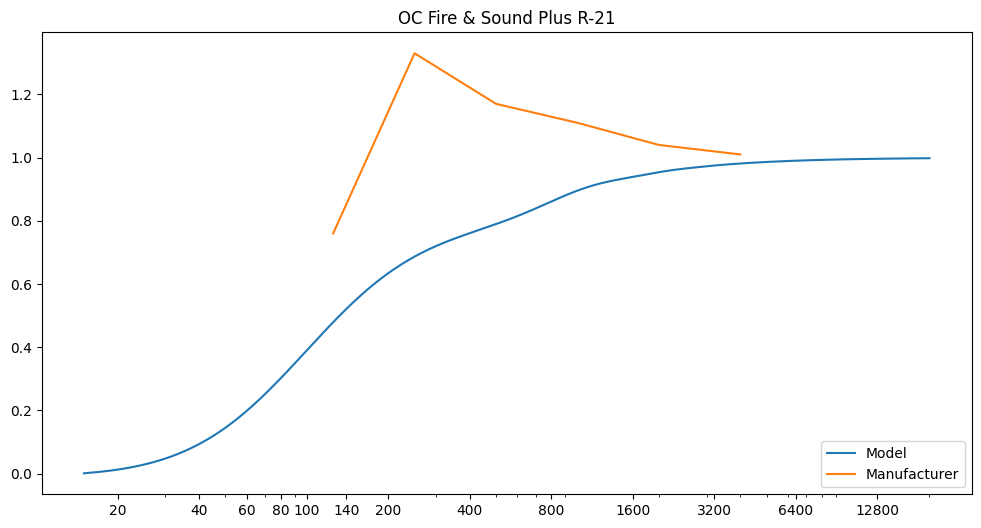

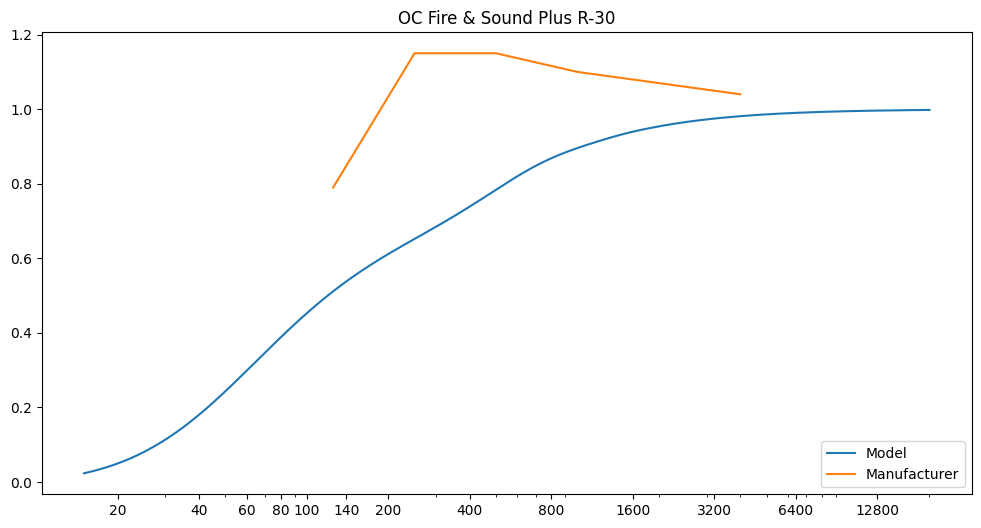

In [11]:
for name, info in materials.items():
    if "a" not in info:
        continue
    spec = info["a"]
    plot(
        f,
        {
            "Model": porous_absorber(
                f, sigma=info["sigma"], thickness=info["thickness"], air_gap=0
            ),
            "Manufacturer": (spec.keys(), spec.values()),
        },
        title=name,
        loc="lower right",
    )